In [33]:
from optparse import OptionParser
import json
import os
import pickle
import random
import re
import pandas as pd
import pysam
import h5py
import numpy as np

import matplotlib.pyplot as plt
from cooltools.lib.numutils import set_diag
from scipy.stats import spearmanr, pearsonr

In [34]:
# import tensorrt as trt (if installed, it's not used by Akita anyways)
import tensorflow as tf
from basenji import seqnn, stream, dataset, dna_io

In [35]:
from akita_utils.utils import ut_dense

In [36]:
os.environ["CUDA_VISIBLE_DEVICES"] = '-1' ### run on CPU
print(tf.config.list_physical_devices('GPU'))

[]


In [37]:
main_dir = "/project/fudenber_735/tensorflow_models/akita/v1/"
model_file = main_dir + "model_best.h5"
params_file = main_dir + "params.json"

In [38]:
### load params, specify model ###

with open(params_file) as params_open:
    params = json.load(params_open)
    params_model = params['model']
    params_train = params['train']

seqnn_model = seqnn.SeqNN(params_model)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 sequence (InputLayer)       [(None, 1048576, 4)]         0         []                            
                                                                                                  
 stochastic_reverse_complem  ((None, 1048576, 4),         0         ['sequence[0][0]']            
 ent_1 (StochasticReverseCo   ())                                                                 
 mplement)                                                                                        
                                                                                                  
 stochastic_shift_1 (Stocha  (None, 1048576, 4)           0         ['stochastic_reverse_complemen
 sticShift)                                                         t_1[0][0]']             

In [39]:
### restore model ###
# note: run %%bash get_model.sh 
# if you have not already downloaded the model
seqnn_model.restore(model_file)
print('successfully loaded')

successfully loaded


In [40]:
### names of targets ###
data_dir = main_dir + "data/"

hic_targets = pd.read_csv(data_dir+'/targets.txt',sep='\t')
hic_file_dict_num = dict(zip(hic_targets['index'].values, hic_targets['file'].values) )
hic_file_dict     = dict(zip(hic_targets['identifier'].values, hic_targets['file'].values) )
hic_num_to_name_dict = dict(zip(hic_targets['index'].values, hic_targets['identifier'].values) )

# read data parameters
data_stats_file = '%s/statistics.json' % data_dir
with open(data_stats_file) as data_stats_open:
    data_stats = json.load(data_stats_open)
seq_length = data_stats['seq_length']
target_length = data_stats['target_length']
hic_diags =  data_stats['diagonal_offset']
target_crop = data_stats['crop_bp'] // data_stats['pool_width']
target_length1 = data_stats['seq_length'] // data_stats['pool_width']

## Make predictions for saved tfrecords

In [41]:
v1_data_split_path = "/project/fudenber_735/tensorflow_models/akita/v1/data/sequences.bed"

In [42]:
all_test_V1_seqs = pd.read_csv(v1_data_split_path, sep='\t', names=['chr','start','stop','type'])
all_test_V1_seqs = all_test_V1_seqs.iloc[all_test_V1_seqs['type'].values=='test']

In [44]:
overlap_test = pd.read_csv("v1_v2_sequences.tsv", sep='\t')

In [46]:
# reading inputs and targets
data_dir_v1 = "/project/fudenber_735/tensorflow_models/akita/v1/data/"
test_data_v1 = dataset.SeqDataset(data_dir_v1, 'test', batch_size=8)
test_inputs, test_targets = test_data_v1.numpy(return_inputs=True, return_outputs=True)

In [ ]:
# pearson R across the full text set (413 test sequences)
# pearR = pearsonr(seqnn_model.model.predict(test_inputs[:,:,:]).flatten(), test_targets[:,:,:].flatten())

In [ ]:
# pearR[0]

In [21]:
test_MSE = []
test_Spearman = []

all_preds = []
all_targets = []

In [22]:
from akita_utils.stats_utils import plot_map

In [23]:
for ind, row in overlap_test.iterrows():
    if ind % 10 == 0:
        print(f"Index: {ind}")
    chr, seq_start, seq_end = row.chr, row.start, row.stop
    myseq_str = chr+':'+str(seq_start)+'-'+str(seq_end)
    print("\t - ", myseq_str)

    # find index in the all test sequences
    index = np.where( (all_test_V1_seqs['chr'].values== chr) *
                         (all_test_V1_seqs['start'].values== int(seq_start))*
                         (all_test_V1_seqs['stop'].values==  int(seq_end))  )[0][0] 

    test_target = test_targets[index:index+1,:,:]
    test_pred = seqnn_model.model.predict(test_inputs[index:index+1,:,:])

    all_targets.append(test_target[0,:,:])
    all_preds.append(test_pred[0,:,:])
    
    # test_target_maps = ut_dense(test_target[0,:,:])
    # test_pred_maps = ut_dense(test_pred[0,:,:])

    # print("target: ")
    # plot_map(test_target_maps[:,:,0])
    # print("prediction: ")
    # plot_map(test_pred_maps[:,:,0])
    
    MSE = [np.mean((test_target[0,:,target_index] - test_pred[0,:,target_index]) ** 2) for target_index in range(test_pred.shape[2])]
    test_MSE.append(MSE)

    spearman = [spearmanr(test_pred[0,:,target_index], test_target[0,:,target_index])[0] for target_index in range(test_pred.shape[2])]
    test_Spearman.append(spearman)
    
    print()

Index: 0
	 -  chr1:72345600-73394176
1/1 [==============================] - 0s 448ms/step

	 -  chr1:72869888-73918464
1/1 [==============================] - 0s 409ms/step

	 -  chr1:73394176-74442752
1/1 [==============================] - 0s 433ms/step

	 -  chr1:73918464-74967040
1/1 [==============================] - 0s 425ms/step

	 -  chr1:74442752-75491328
1/1 [==============================] - 0s 418ms/step

	 -  chr1:74967040-76015616
1/1 [==============================] - 0s 408ms/step

	 -  chr1:75491328-76539904
1/1 [==============================] - 0s 431ms/step

	 -  chr1:76015616-77064192
1/1 [==============================] - 0s 401ms/step

	 -  chr1:76539904-77588480
1/1 [==============================] - 0s 390ms/step

	 -  chr1:109703168-110751744
1/1 [==============================] - 0s 377ms/step

Index: 10
	 -  chr1:110227456-111276032
1/1 [==============================] - 0s 395ms/step

	 -  chr1:110751744-111800320
1/1 [==============================] - 0s 403

In [24]:
overlap_test = overlap_test.copy()

test_MSE_array = np.array(test_MSE)
test_Spearman_array = np.array(test_Spearman)

for target_index in range(5):
    overlap_test.loc[:, f"v1_MSE_{target_index}"] = test_MSE_array[:, target_index]
    overlap_test.loc[:, f"v1_S_{target_index}"] = test_Spearman_array[:, target_index]

In [25]:
# Now perform your operation
overlap_test.loc[:, 'v1_MSE'] = overlap_test[[f"v1_MSE_{target_index}" for target_index in range(5)]].mean(axis=1)
overlap_test.loc[:, 'v1_S'] = overlap_test[[f"v1_S_{target_index}" for target_index in range(5)]].mean(axis=1)

In [27]:
overlap_test.to_csv("v1_results.tsv", sep="\t", index=False, header=True)

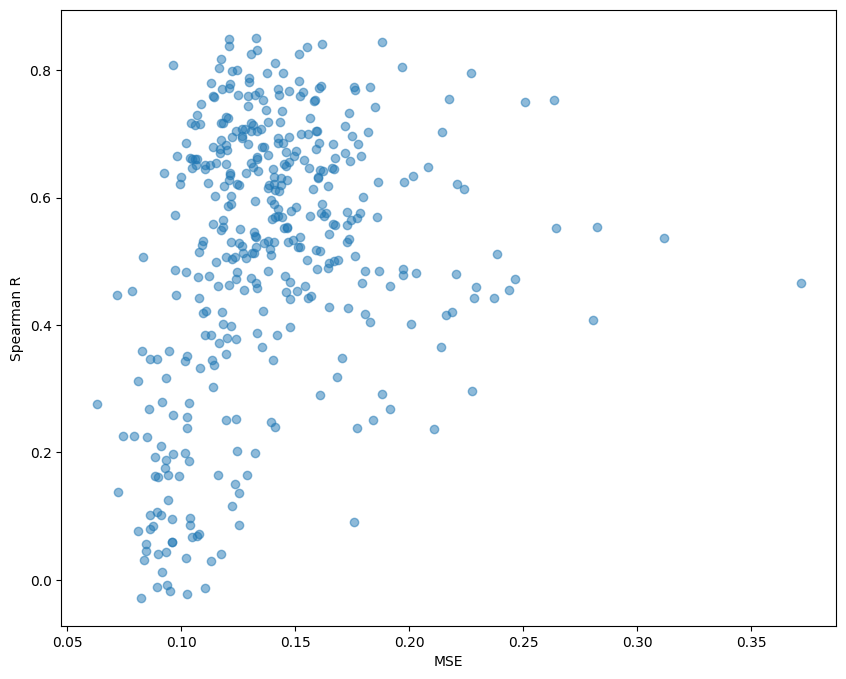

In [26]:
fig, ax = plt.subplots(figsize=(10, 8))

scatter = ax.scatter(overlap_test["v1_MSE"], overlap_test["v1_S"], alpha=0.5)

ax.set_xlabel("MSE")
ax.set_ylabel("Spearman R")

# ax.set_title(f"Correlation between boundary SCD and dot SCD; Pearson Correlation = {rounded_pearson_corr}")

# plt.savefig("./plots/boundarySCD_vs_dotSCD.png", bbox_inches="tight")

plt.show()

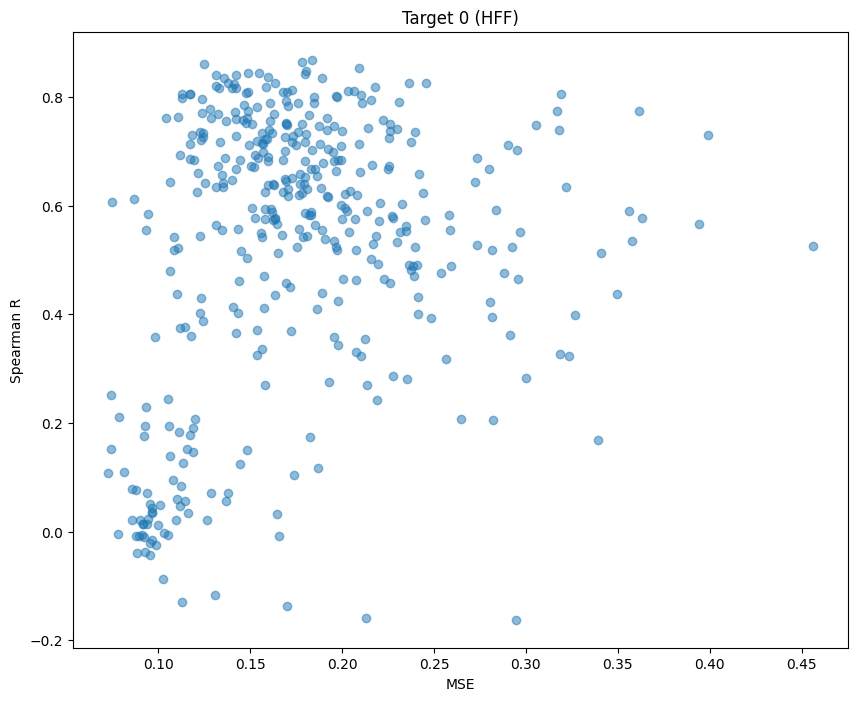

In [29]:
fig, ax = plt.subplots(figsize=(10, 8))

scatter = ax.scatter(overlap_test["v1_MSE_0"], overlap_test["v1_S_0"], alpha=0.5)

ax.set_xlabel("MSE")
ax.set_ylabel("Spearman R")

ax.set_title("Target 0 (HFF)")

# plt.savefig("./plots/boundarySCD_vs_dotSCD.png", bbox_inches="tight")

plt.show()

## Pearson Correlation

In [30]:
all_preds = np.array(all_preds)
all_targets = np.array(all_targets)

In [31]:
pearR = pearsonr(all_preds.flatten(), all_targets.flatten())

In [32]:
pearR

PearsonRResult(statistic=0.6203657089345832, pvalue=0.0)

## Plotting Maps

In [48]:
# very close to diagonal -> chr1:73918464-74967040
# better performance -> chr9:132390912-133439488

In [49]:
fig_examples = [   'chr1:73918464-74967040',
                    'chr9:132390912-133439488']
fig_inds = []
for seq in fig_examples:
    print(seq)
    chrm,start,stop = seq.split(':')[0], seq.split(':')[1].split('-')[0], seq.split(':')[1].split('-')[1]
    test_ind = np.where( (all_test_V1_seqs['chr'].values== chrm) *
                         (all_test_V1_seqs['start'].values== int(start))*
                         (all_test_V1_seqs['stop'].values==  int(stop ))  )[0][0]
    fig_inds.append(test_ind)
fig_inds

chr1:73918464-74967040
chr9:132390912-133439488


[84, 263]

In [52]:
from akita_utils.stats_utils import plot_map

 
chr1:73918464-74967040
1/1 [==============================] - 0s 402ms/step
target: 


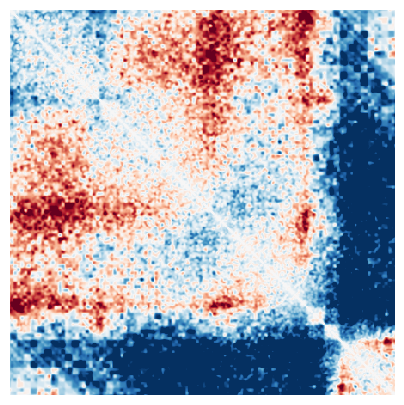

prediction: 


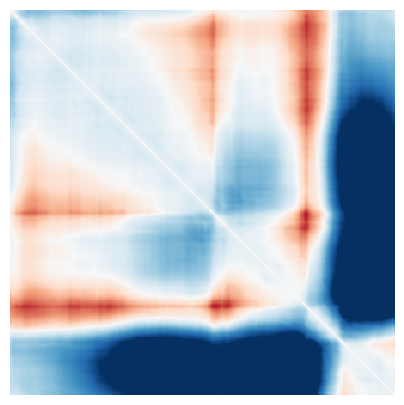

 
chr9:132390912-133439488
1/1 [==============================] - 0s 418ms/step
target: 


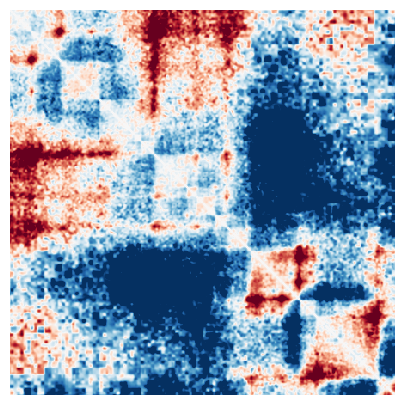

prediction: 


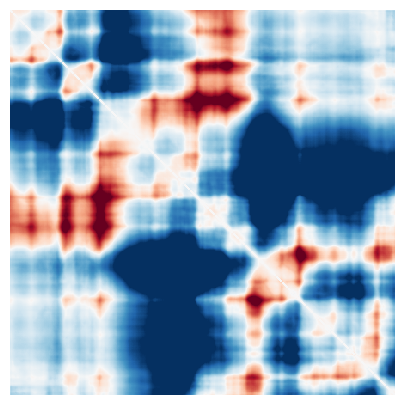

In [61]:
## make predictions and plot the three examples above ###

for test_index in fig_inds:
    chrm, seq_start, seq_end = all_test_V1_seqs.iloc[test_index][0:3]
    myseq_str = chrm+':'+str(seq_start)+'-'+str(seq_end)
    print(' ')
    print(myseq_str)
    
    test_target = test_targets[test_index:test_index+1,:,:]
    test_pred = seqnn_model.model.predict(test_inputs[test_index:test_index+1,:,:])

    test_target_maps = ut_dense(test_target[0,:,:])
    test_pred_maps = ut_dense(test_pred[0,:,:])

    # maps averaged over all targets
    ave_test_target_maps = np.mean(test_target_maps, axis=2)
    ave_test_pred_maps = np.mean(test_pred_maps, axis=2)
    
    print("target: ")
    plot_map(ave_test_target_maps) #vmin=-2, vmax=2)
    print("prediction: ")
    plot_map(ave_test_pred_maps) #vmin=-2, vmax=2)
    